In [1]:
import numpy as np
import matplotlib.pyplot  as plt

In [2]:
from sklearn.metrics import mean_squared_error as MSE
from scipy import optimize as scop

In [3]:
from numba import njit

@njit
def euler_numba_helper(x, y, c):
    for i in range(1, len(x)):
        x[i] = x[i-1] + (y[i-1] - x[i-1]) * c

def calculate_I_out(x, *args):
        
    kwargs = args[-1]
    
    if kwargs.get('log_scale', False):
        x = np.exp(x)
        
    C_p, C_m, a0_m, b0_m, delta_m, s_m, a0_h, b0_h, delta_h, s_h, R_m, R_p, g_max, g_leak = x

    v_list = kwargs['v_list']
    k_list = kwargs['k_list']
    
    t = kwargs['t']
    dt = t[1] - t[0]
    
    v_p = np.zeros_like(t)

    v_0_list = np.zeros_like(t)
    V_m_list = np.zeros_like(t)

    v_0_list = np.zeros_like(t)
    v_0_list[k_list] = 1
    v_0_list = np.cumsum(v_0_list)

    V_m_list = v_list[v_0_list.astype(int) + 1]
    v_0_list = v_list[v_0_list.astype(int)]
    
    v_p = V_m_list + (v_0_list - V_m_list) * np.exp(-t / (R_p * C_p))
    
    v = np.zeros_like(v_p)
    v[0] = -80
    euler_numba_helper(v, v_p, dt / (R_m * C_m))
    
    alfa_m  = a0_m * np.exp(-delta_m * v / (-s_m))
    betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
    
    alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
    betta_h = b0_h * np.exp((1-delta_h) * v / s_h)
    
    tau_m = 1/(betta_m + alfa_m)
    tau_h = 1/(betta_h + alfa_h)
    v_const = -80
    
    m_inf = 1/(1+betta_m/alfa_m)
    h_inf = 1/(1+betta_h/alfa_h)
    
    m0 = 1/(1+(b0_m/a0_m)*np.exp(v_const/(-s_m)))
    h0 = 1/(1+(b0_h/a0_h)*np.exp(v_const/s_h))

    m = m_inf + (m0-m_inf)*np.exp(-t/tau_m)
    h = h_inf + (h0-h_inf)*np.exp(-t/tau_h)
    
    v_rev = 18

    i_c = 1e9 * C_m * np.diff(v) / dt
    i_p = 1e9 * C_p * np.diff(v_p) / dt

    i_c = np.concatenate([i_c, i_c[-1:]])
    i_p = np.concatenate([i_p, i_p[-1:]])

    i_leak = g_leak * v

    tau_z = 1e-12 * 5e8
    I_in =  g_max * h * (m**3) * (v - v_rev) + i_p + i_c + i_leak
    
    I_out = np.zeros_like(I_in)
    I_out[0] = I_in[0]
    euler_numba_helper(I_out, I_in, dt / tau_z)

    return I_out

In [4]:
x_true = [1e-15, 1e-11, 5e3, 8, 0.85, 6, 2, 4e4, 0.5, 6, 5e8, 5e6, 1e3, 1e-2]
x_true_log = np.log(x_true)

t = np.load('../data/time.npy')

v_list = np.array([-80, -80, -70, -80, -10, -80])
k_list = np.array([77, 1077, 2077, 4077]) + 1

dt = t[1] - t[0]

kwargs = dict(v_list = v_list,
              k_list = k_list,
              t = t,
              log_scale = True)

data = calculate_I_out(x_true_log, kwargs) # np.load('../data/simulated_func.npy')

In [5]:
def loss(x, *args):
    kwargs = args[-1]
    data = args[0]
    return MSE(data, calculate_I_out(x, *args))

In [6]:
%%timeit
loss(x_true_log, data, kwargs)

2.31 ms ± 438 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [7]:
x0 = x_true_log - 1
bounds = np.vstack([x_true_log  - 2, x_true_log + 2]).T

loss(x0, data, kwargs)

20042.966439562766

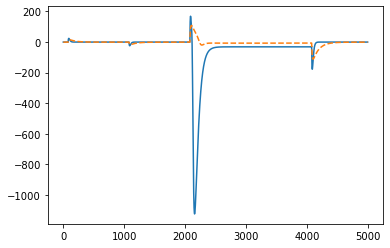

In [8]:
plt.plot(calculate_I_out(x0, kwargs))
plt.plot(data, '--')

### minimize

In [9]:
%%time
res = scop.minimize(loss, x0, bounds=bounds, args=(data, kwargs))

CPU times: user 1.54 s, sys: 725 µs, total: 1.54 s
Wall time: 1.57 s


In [10]:
res.x

array([-36.53877639, -25.52219086,   6.51719319,   4.07944154,
         1.83748107,  -0.20824053,  -1.30685282,  12.59663473,
         1.30685282,   3.79175947,  19.89670325,  14.42494847,
         4.90775528,  -3.46492464])

In [11]:
loss(res.x, data, kwargs)

38.557524862653985

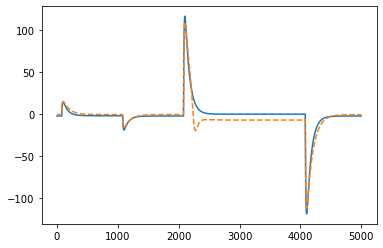

In [12]:
plt.plot(calculate_I_out(res.x, kwargs))
plt.plot(data, '--')

### differential_evolution

In [13]:
%%time
res = scop.differential_evolution(loss,
                                  bounds=bounds,
                                  args=(data, kwargs),
                                  maxiter=100, # I don't want to wait too long
                                  #disp=True,
                                  workers=-1)

/home/andrey/WORK/HPL/Code/conda_env/lib/python3.8/site-packages/scipy/optimize/_differentialevolution.py:495: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  warnings.warn("differential_evolution: the 'workers' keyword has"


CPU times: user 7.47 s, sys: 538 ms, total: 8.01 s
Wall time: 28.9 s


In [14]:
res

     fun: 0.01626903827536354
     jac: array([-1.16780187e-04,  6.57963213e-05,  2.02338129e-06, -1.11295002e-04,
       -5.15663901e-05,  5.28743719e-07, -3.99291713e-05,  4.10040024e-05,
        3.54230532e-07,  1.06765986e-04, -3.06490918e-06,  0.00000000e+00,
       -9.80777965e-06,  4.49786044e-05])
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 23130
     nit: 100
 success: False
       x: array([-36.11618895, -25.32884401,   8.5509551 ,   3.39644277,
         0.16229696,   2.09025627,   2.57166648,  10.50213471,
         0.71918934,   1.75655493,  20.02355407,  17.35595435,
         4.91095789,  -4.59015693])

In [15]:
loss(res.x, data, kwargs)

0.01626903827536354

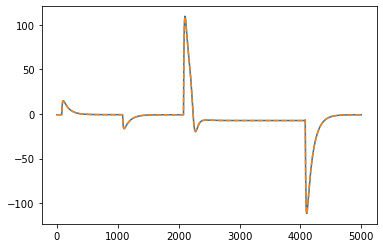

In [16]:
plt.plot(calculate_I_out(res.x, kwargs))
plt.plot(data, '--')

### dual_annealing

In [17]:
%%time
res = scop.dual_annealing(loss, bounds=bounds, x0 = x_true_log, args=(data, kwargs))

CPU times: user 59.9 s, sys: 2.28 s, total: 1min 2s
Wall time: 1min 2s


In [18]:
res

     fun: 0.0
 message: ['Maximum number of iteration reached']
    nfev: 29711
    nhev: 0
     nit: 1000
    njev: 114
  status: 0
 success: True
       x: array([-34.53877639, -25.32843602,   8.51719319,   2.07944154,
        -0.16251893,   1.79175947,   0.69314718,  10.59663473,
        -0.69314718,   1.79175947,  20.03011866,  15.42494847,
         6.90775528,  -4.60517019])

In [19]:
loss(res.x, data, kwargs)

0.0

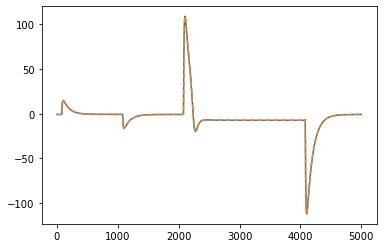

In [20]:
plt.plot(calculate_I_out(res.x, kwargs))
plt.plot(data, '--')